In [7]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style='whitegrid')


In [3]:
# Step 1: Load dataset
# Replace 'ecom.csv' with your actual file name if different
df = pd.read_csv('ecom.csv')  

# Step 0.5: Keep a copy of original dataset for EDA / visualization
df_vis = df.copy()

# Quick view of the first few rows
print("First 5 rows of dataset:")
display(df.head())

# Basic info about data types and non-null counts
print("\nDataset Info:")
df.info()

# Statistical summary of numeric columns
print("\nStatistical Summary:")
display(df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


First 5 rows of dataset:


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet 

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000



Missing values in each column:
CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64


In [4]:
# Step 2 - Cell 1: Fix types and drop unnecessary columns

# Convert 'Total Charges' to numeric (coerce errors to NaN, though ideally none)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Drop unnecessary columns
columns_to_drop = ['CustomerID', 'Count', 'Lat Long', 'Latitude', 'Longitude', 
                   'Country', 'State', 'Churn Label', 'Churn Reason']
df.drop(columns=columns_to_drop, inplace=True)

# Quick check
print("Columns after dropping unnecessary ones:")
print(df.columns)
print("\nMissing values after type conversion:")
print(df.isnull().sum())


Columns after dropping unnecessary ones:
Index(['City', 'Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Churn Score', 'CLTV'],
      dtype='object')

Missing values after type conversion:
City                  0
Zip Code              0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges     

In [8]:
# Step 2 - Cell 2: Preprocessing (Fixed Version)

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Fill missing numeric values
if 'Total Charges' in df.columns:
    df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)

# List of binary categorical columns (only keep those actually in df)
binary_cols = [col for col in ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 
                               'Phone Service', 'Multiple Lines', 'Paperless Billing'] 
               if col in df.columns]

# Apply Label Encoding to binary columns
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# Multi-class categorical columns (check actual column names)
possible_multi_cols = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaymentMethod',
    # also include space versions if your data uses them
    'Internet Service', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV',
    'Streaming Movies', 'Payment Method'
]

# Select only those that exist in df
multi_cols = [col for col in possible_multi_cols if col in df.columns]

# Apply One-Hot Encoding safely
if multi_cols:
    df = pd.get_dummies(df, columns=multi_cols, drop_first=True)
else:
    print("⚠️ No matching categorical columns found for One-Hot Encoding.")

# Scaling numeric columns (only if they exist)
num_cols = [col for col in ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV'] if col in df.columns]

if num_cols:
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
else:
    print("⚠️ No numeric columns found for scaling.")

# Final check
print("\n✅ Columns after encoding and scaling:")
print(df.columns.tolist())

print("\n🔹 Sample data:")
display(df.head())


⚠️ No matching categorical columns found for One-Hot Encoding.

✅ Columns after encoding and scaling:
['City', 'Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score', 'CLTV', 'Internet Service_Fiber optic', 'Internet Service_No', 'Online Security_No internet service', 'Online Security_Yes', 'Online Backup_No internet service', 'Online Backup_Yes', 'Device Protection_No internet service', 'Device Protection_Yes', 'Tech Support_No internet service', 'Tech Support_Yes', 'Streaming TV_No internet service', 'Streaming TV_Yes', 'Streaming Movies_No internet service', 'Streaming Movies_Yes', 'Contract_One year', 'Contract_Two year', 'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 'Payment Method_Mailed check']

🔹 Sample data:


,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Paperless Billing,...,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,Los Angeles,90003,1,0,0,0,-1.236724,1,0,1,...,False,False,False,False,False,False,False,False,False,True
1,Los Angeles,90005,0,0,0,1,-1.236724,1,0,1,...,False,False,False,False,False,False,False,False,True,False
2,Los Angeles,90006,0,0,0,1,-0.992402,1,2,1,...,False,False,True,False,True,False,False,False,True,False
3,Los Angeles,90010,0,0,1,1,-0.177995,1,2,1,...,True,False,True,False,True,False,False,False,True,False
4,Los Angeles,90015,1,0,0,1,0.677133,1,2,1,...,False,False,True,False,True,False,False,False,False,False


In [27]:
# Step 2.5: Export cleaned dataset for later use in web app
import os

# Make sure 'models' folder exists
os.makedirs('models', exist_ok=True)

# Save cleaned DataFrame
cleaned_data_path = os.path.join('models', 'cleaned_data.csv')
df.to_csv(cleaned_data_path, index=False)
print(f"✅ Cleaned dataset saved to: {cleaned_data_path}")


✅ Cleaned dataset saved to: models\cleaned_data.csv


In [28]:
# Step 3 - Cell 1: Train/Test Split (Safe Version)

# Columns to drop if they exist
drop_cols = [col for col in ['Churn Value', 'City', 'Zip Code'] if col in df.columns]

X = df.drop(columns=drop_cols)
y = df['Churn Value']  # make sure this column exists

# Split data: 80% train, 20% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (5634, 31)
Test set size: (1409, 31)


In [29]:
# Step 3 - Cell 2: Train Logistic Regression and Random Forest

# Ensure models folder exists
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation function
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("\n")

# Evaluate models
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# -----------------------------
# Save the Random Forest model
# -----------------------------
import joblib
joblib.dump(rf, 'models/rf_model.pkl')
print("Random Forest model saved to models/rf_model.pkl")

# -----------------------------
# Save the cleaned dataset for web app
# -----------------------------
df.to_csv('models/cleaned_data.csv', index=False)
print("Cleaned dataset saved to models/cleaned_data.csv")


--- Logistic Regression ---
Accuracy: 0.9063
Confusion Matrix:
 [[939  70]
 [ 62 338]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      1009
           1       0.83      0.84      0.84       400

    accuracy                           0.91      1409
   macro avg       0.88      0.89      0.89      1409
weighted avg       0.91      0.91      0.91      1409



--- Random Forest ---
Accuracy: 0.9255
Confusion Matrix:
 [[973  36]
 [ 69 331]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      1009
           1       0.90      0.83      0.86       400

    accuracy                           0.93      1409
   macro avg       0.92      0.90      0.91      1409
weighted avg       0.92      0.93      0.92      1409



Random Forest model saved to models/rf_model.pkl
Cleaned dataset saved to models/cleaned_data.csv


In [32]:
import os
import joblib

# Ensure 'models' folder exists
if not os.path.exists('models'):
    os.makedirs('models')

# Save Random Forest model
joblib.dump(rf, 'models/rf_model.pkl')

# Save Logistic Regression model
joblib.dump(lr, 'models/lr_model.pkl')

print("Models saved successfully in 'models/' folder!")


# Save cleaned dataset for Flask app
df.to_csv('models/cleaned_data.csv', index=False)
print("Cleaned dataset saved to 'models/cleaned_data.csv'")


Models saved successfully in 'models/' folder!
Cleaned dataset saved to 'models/cleaned_data.csv'


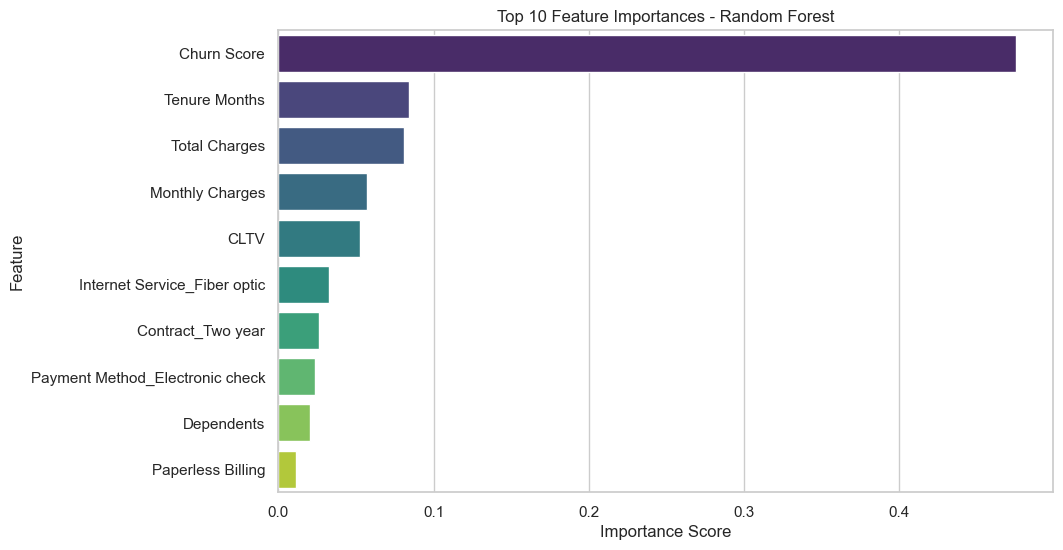

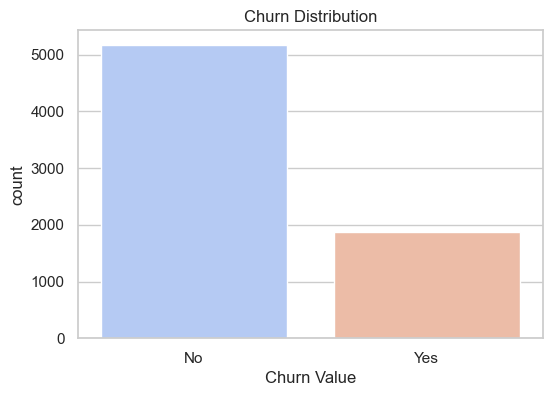

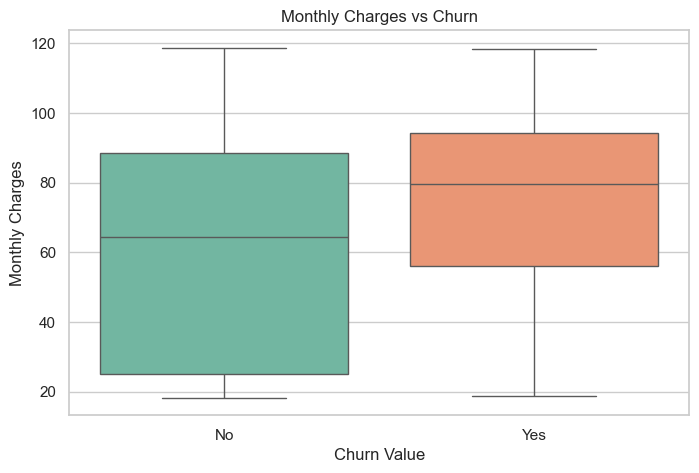

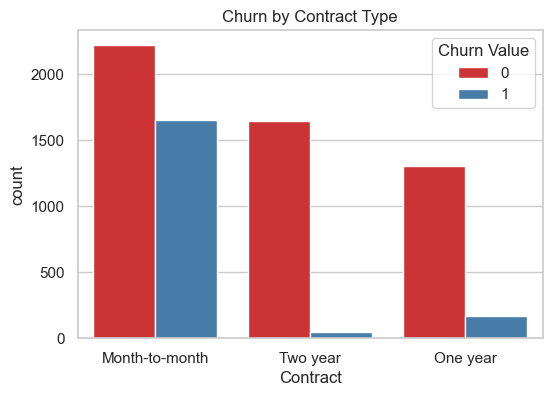

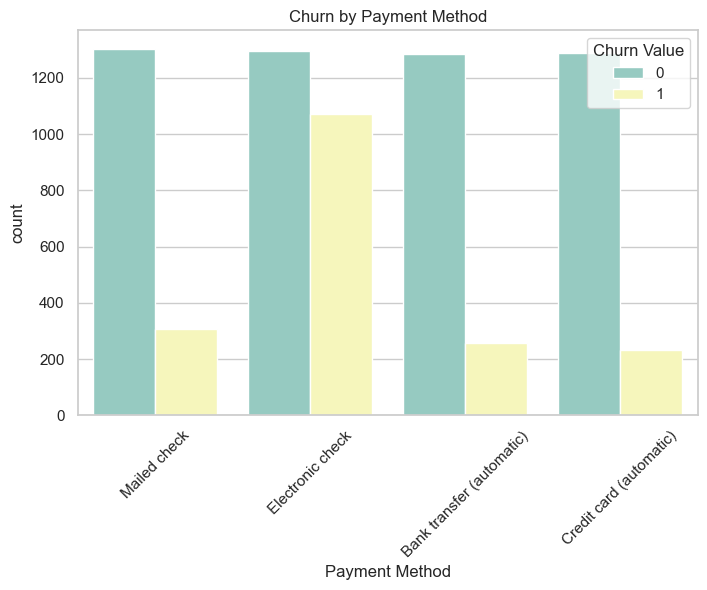

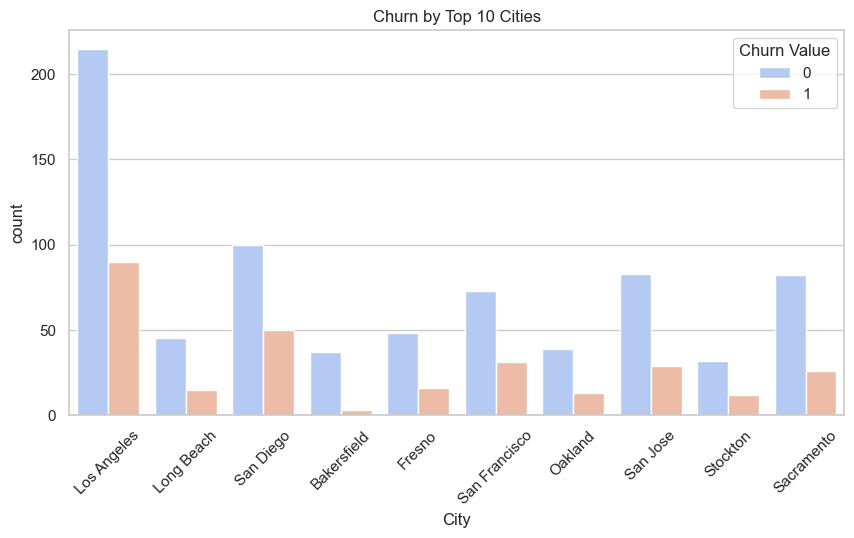

✅ Cleaned and preprocessed data saved at: C:\Users\rutvi\Machine Learning\ML Project\models\cleaned_data.csv


In [33]:
# Step 4: Feature Importance + Key EDA Graphs

import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------
# 1. Feature Importance from Random Forest
# -----------------------------
try:
    importances = rf.feature_importances_
    features = X_train.columns

    # Ensure lengths match
    if len(importances) == len(features):
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

        # Plot top 10 features
        plt.figure(figsize=(10,6))
        sns.barplot(x=feat_imp[:10], y=feat_imp[:10].index, palette='viridis')
        plt.title("Top 10 Feature Importances - Random Forest")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.show()
    else:
        print("⚠️ Feature importances length does not match X_train columns.")
except Exception as e:
    print("⚠️ Could not plot feature importances:", e)


# -----------------------------
# 2. Churn Distribution
# -----------------------------
if 'Churn Value' in df_vis.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_vis, x='Churn Value', palette='coolwarm')
    plt.title("Churn Distribution")
    plt.xticks([0,1], ['No', 'Yes'])
    plt.show()


# -----------------------------
# 3. Monthly Charges vs Churn
# -----------------------------
if 'Churn Value' in df_vis.columns and 'Monthly Charges' in df_vis.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df_vis, x='Churn Value', y='Monthly Charges', palette='Set2')
    plt.title("Monthly Charges vs Churn")
    plt.xticks([0,1], ['No', 'Yes'])
    plt.show()


# -----------------------------
# 4. Churn by Contract Type
# -----------------------------
if 'Contract' in df_vis.columns and 'Churn Value' in df_vis.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_vis, x='Contract', hue='Churn Value', palette='Set1')
    plt.title("Churn by Contract Type")
    plt.show()


# -----------------------------
# 5. Churn by Payment Method
# -----------------------------
if 'Payment Method' in df_vis.columns and 'Churn Value' in df_vis.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df_vis, x='Payment Method', hue='Churn Value', palette='Set3')
    plt.title("Churn by Payment Method")
    plt.xticks(rotation=45)
    plt.show()


# -----------------------------
# 6. Optional: Churn by City (top 10 cities)
# -----------------------------
if 'City' in df_vis.columns and 'Churn Value' in df_vis.columns:
    top_cities = df_vis['City'].value_counts().nlargest(10).index
    plt.figure(figsize=(10,5))
    sns.countplot(data=df_vis[df_vis['City'].isin(top_cities)], x='City', hue='Churn Value', palette='coolwarm')
    plt.title("Churn by Top 10 Cities")
    plt.xticks(rotation=45)
    plt.show()


# -----------------------------
# 7. Save cleaned/preprocessed dataset for Flask
# -----------------------------
save_path = os.path.join(os.getcwd(), "models", "cleaned_data.csv")
df.to_csv(save_path, index=False)
print(f"✅ Cleaned and preprocessed data saved at: {save_path}")
